<a href="https://colab.research.google.com/github/SBiscardi/cd-202202-santiago-biscardi/blob/master/Taller7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalaciones

In [ ]:
!pip install pyproj
!pip install geopandas
!sudo apt install libspatialindex-dev
!pip install rtree

!pip install cython
!pip install cartopy

!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: Shapely 1.8.5.post1
Uninstalling Shapely-1.8.5.post1:
  Successfully uninstalled Shapely-1.8.5.post1
Looking in ind

In [ ]:
import geopandas
import pandas as pd
import numpy as np
import geopandas as gpd
import urllib
from decimal import DivisionByZero
from math import sqrt
import geopandas as gpd

pd.options.mode.chained_assignment = None

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy
import cartopy.crs as ccrs                   
import cartopy.feature as cfeature          
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade
import pyproj
from shapely.geometry import Polygon, mapping
from shapely.geometry import Point, Polygon
from shapely import wkt

# Obtener datos de dengue

In [ ]:
ruta = 'https://foscalinternacional.com/datasets/eventos_dengue_2020.csv'
df = pd.read_csv(ruta)
P = pyproj.Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=True)
df['x'], df['y'] = P(df['longitud'], df['latitud'])
url = 'https://foscal.net/cartografia/'

file_list= ["68276_urbano.cpg","68276_urbano.dbf","68276_urbano.prj","68276_urbano.qmd","68276_urbano.shp","68276_urbano.shx"]

for file in file_list:
  urllib.request.urlretrieve(url+file, file)

  

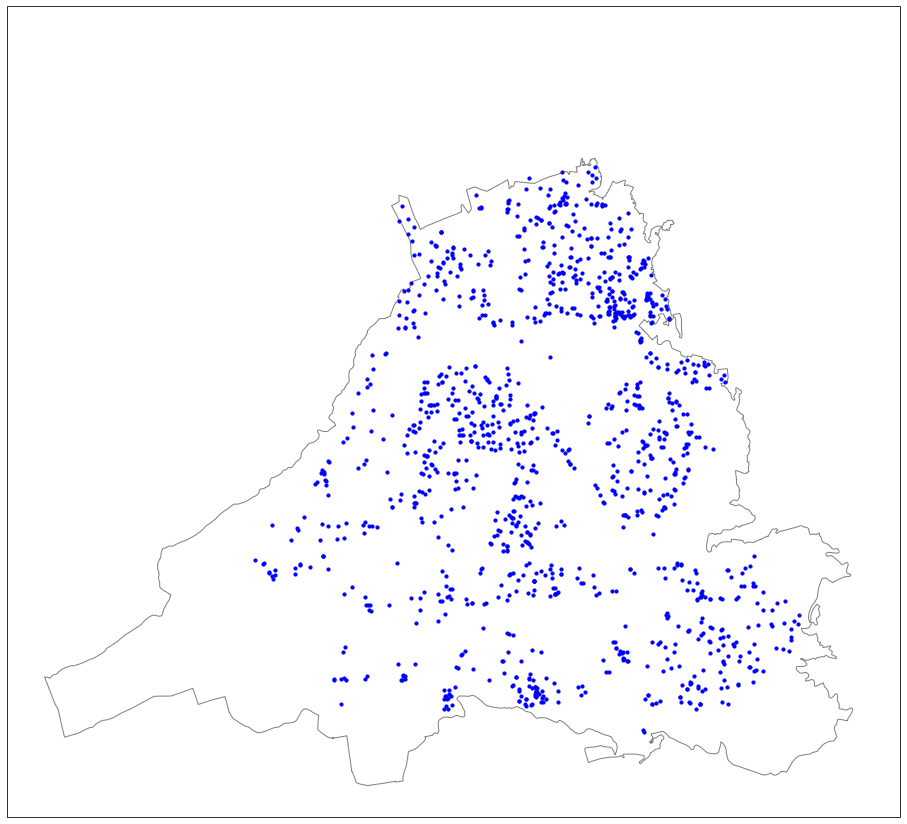

In [ ]:
subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(16, 16), subplot_kw=subplot_kw)
lower_lon = -73.135
upper_lon = -73.070
lower_lat = 7.051
upper_lat = 7.110

ax.set_extent([lower_lon, upper_lon, lower_lat, upper_lat])

reader = shapereader.Reader('68276_urbano.shp')

for geometria in reader.geometries():
    ax.add_geometries([geometria], ccrs.PlateCarree(), facecolor='white', edgecolor='gray')

ax.scatter(df['longitud'], df['latitud'], zorder=10, c='b', s=10)

ax.add_line
plt.show()

In [ ]:
for geometria in reader.geometries():
  geo = geometria

geod = pyproj.Geod(ellps="WGS84")
area = abs(geod.geometry_area_perimeter(geo)[0])


# Generar puntos aleatorios

In [ ]:
reader = shapereader.Reader('68276_urbano.shp')
points_to_use = df.shape[0]

for geometry in reader.geometries():
  polygon = geometry

def random_points_in_bound(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

In [ ]:
gdf_poly = gpd.GeoDataFrame(index=["florida"], geometry=[polygon])

In [ ]:
def generate_random_points():
  x,y = random_points_in_bound(polygon, 10_000)
  dfGen = pd.DataFrame()
  dfGen['points'] = list(zip(x,y))
  dfGen['points'] = dfGen['points'].apply(Point)
  gdf_points = gpd.GeoDataFrame(dfGen, geometry='points')

  Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

  pnts_in_poly = gdf_points[Sjoin.index_right=='florida']
  pnts_in_poly.index = range(0,len(pnts_in_poly))
  pnts_in_poly = dfGen[dfGen.index < points_to_use]
  pnts_in_poly["x"] = [point.x for point in pnts_in_poly["points"].to_list()]
  pnts_in_poly["y"] = [point.y for point in pnts_in_poly["points"].to_list()]
  pnts_in_poly.reset_index()

  points_list = []
  for i in range(df.shape[0]):
    points_list.append([pnts_in_poly.loc[i, 'x'], pnts_in_poly.loc[i, 'y']])

  return points_list

def distance(x1, y1, x2, y2):
  return sqrt((x2-x1)**2 + (y2-y1)**2)

def near_points (pointList, h):
  counter = 0
  pointOneIndex = 0
  for pointOne in pointList:
    if(pointOneIndex +1 < len(pointList)):
      for pointTwo in pointList[pointOneIndex + 1:len(pointList)]:
        x1 = pointOne[0]
        x2 = pointTwo[0]
        y1 = pointOne[1]
        y2 = pointTwo[1]
        if (sqrt((x2-x1)**2 + (y2-y1)**2) <= h):
          counter += 1
    pointOneIndex += 1
  return counter

def k_value(point_list, area, h):
  return (area/(len(point_list)**2)) * near_points(point_list, h)

def generate_values_to_graph(original_list, ranList, h):
  result = []
  first_k = k_value(original_list, area, h)
  result.append(first_k)

  totalPoints = len(original_list)
  i = 0
  for randSet in ranList:
    print(f'Generando valor k {i}')
    result.append(k_value(randSet, area, h))
    i+=1
  result.sort()
  return [h, first_k, np.percentile(result, 2.5), np.percentile(result, 97.5)]

In [ ]:
original_list = []
for i in range(df.shape[0]):
  original_list.append([df.loc[i, 'x'], df.loc[i, 'y']])

In [ ]:
result = []
randList = []
totalPoints = len(original_list)

print('Empezando a generar los datos aleatorios')
for i in range(99):
  print(f'Datos Aleatorios: {i}')
  randList.append(generate_random_points())

print('Empezando a calcular los valores a graficar')
for i in range(5,100,5):
  print(f'Valor {i}')
  result.append(generate_values_to_graph(original_list, randList, i))

print(result)

Empezando a generar los datos aleatorios
Datos Aleatorios: 0
Datos Aleatorios: 1
Datos Aleatorios: 2
Datos Aleatorios: 3
Datos Aleatorios: 4
Datos Aleatorios: 5
Datos Aleatorios: 6
Datos Aleatorios: 7
Datos Aleatorios: 8
Datos Aleatorios: 9
Datos Aleatorios: 10
Datos Aleatorios: 11
Datos Aleatorios: 12
Datos Aleatorios: 13
Datos Aleatorios: 14
Datos Aleatorios: 15
Datos Aleatorios: 16
Datos Aleatorios: 17
Datos Aleatorios: 18
Datos Aleatorios: 19
Datos Aleatorios: 20
Datos Aleatorios: 21
Datos Aleatorios: 22
Datos Aleatorios: 23
Datos Aleatorios: 24
Datos Aleatorios: 25
Datos Aleatorios: 26
Datos Aleatorios: 27
Datos Aleatorios: 28
Datos Aleatorios: 29
Datos Aleatorios: 30
Datos Aleatorios: 31
Datos Aleatorios: 32
Datos Aleatorios: 33
Datos Aleatorios: 34
Datos Aleatorios: 35
Datos Aleatorios: 36
Datos Aleatorios: 37
Datos Aleatorios: 38
Datos Aleatorios: 39
Datos Aleatorios: 40
Datos Aleatorios: 41
Datos Aleatorios: 42
Datos Aleatorios: 43
Datos Aleatorios: 44
Datos Aleatorios: 45
Dat